<a href="https://colab.research.google.com/github/sahilrajiv/Modelling-Mulitscale-Heterogeneity/blob/main/Generating_Multiscale_pattern_using_cantor_sets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Generating Multiscale patten using Cantor sets

You'll have to enter the side length in `sleng,` and number of densities required in `no_of_densities` variables. The algorithm will figure out the position of sites to be occupied. After you've run all the cells, the required data will be saved in the `data.json` file. Instructions of using the data file are attached in the [Loading data and examples notebook](https://drive.google.com/file/d/1jYDwxrg_NXhT30lRu73S6n4Nh-ZRBMyl/view?usp=sharing).

If you've run into any issues or you've any queries regarding the code, please reach out to me at sahilrajivshahi@gmail.com.

Thanks!

In [ ]:
%pprint
get_ipython().run_line_magic('matplotlib', 'notebook')

Pretty printing has been turned OFF


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from functools import reduce
from collections import defaultdict
import time
import math as m
import itertools
from copy import copy

### `sleng` is the side length of the lattice

In [ ]:
sleng=1000

## Generating the template

In [ ]:
gamma=3
no_of_scales= int(m.log(sleng)/m.log(gamma))

def cantor(side_len):
    ls=[(0,side_len)]
    fraction = lambda interval: (interval[1]-interval[0])/gamma
    gap=lambda frac: (frac/3)
    while True:
        yield ls
        ls = [[(k[0]+gap(fraction(k)),k[0]+gap(fraction(k))+fraction(k)), (k[0]+gap(fraction(k))+fraction(k)+gap(fraction(k)),k[1]-gap(fraction(k)))] for k in  ls]
        ls = reduce(lambda x,y:x+y,ls)
        

gen_cantor = cantor(sleng)

levels=dict()
for i in range(no_of_scales):
    levels[i]=next(gen_cantor)

scales=defaultdict(list) #dict of cantor lengths
gap=dict() #dict containing the gap produced at each scale
side=dict() #dict containing the side length of each scale

'''function to obtain the coordinate points from the cantor set'''
def cantor_to_axis():
    for scale in levels.keys():
        for l in levels.get(scale):
            a=np.arange(int(l[0]),int(l[1]+1))
            if a[0]<l[0]:
                a[0]=l[0]
            if a[-1]<l[1]:
                a[-1]=l[1]
            scales[scale].append(a) 
#         if scale>0:         <---------------uncomment this if you don't mind the decimal lenghts at the innermost scale
        gap[scale]=((l[1]-l[0])/3)
        side[scale]=((l[1]-l[0]+1)*4)

cantor_to_axis()

og_pts=defaultdict(dict)  #dictionary of points containing the original template

colors=itertools.cycle(["red","blue"]) 

'''The following function generates the original template shape on a coordinate plane'''
def make_shape():
    for s in scales.keys():
        a=0 
        clr=next(colors)
        if not s==list(scales.keys())[-1]:
            for i in range(len(scales[s])):
                for j in range(len(scales[s])):
                        a=a+1
                        tmp=dict()
                        # plt.plot(scales[s][i], scales[s][j][0]*np.ones(len(scales[s][i])), color='r') #bottom
                        # plt.plot(scales[s][j],(scales[s][i][-1]*np.ones(len(scales[s][j]))), color='r') #top
                        # plt.plot((scales[s][i][-1]*np.ones(len(scales[s][j]))),scales[s][j], color='r') #right
                        # plt.plot(scales[s][j][0]*np.ones(len(scales[s][i])),scales[s][i] , color='r') #left
                        tmp[0]=scales[s][i], scales[s][j][0]*np.ones(len(scales[s][i])) #bottom
                        tmp[1]=scales[s][j],(scales[s][i][-1]*np.ones(len(scales[s][j]))) #top
                        tmp[2]=scales[s][i][-1]*np.ones(len(scales[s][j])),scales[s][j] #right
                        tmp[3]=scales[s][j][0]*np.ones(len(scales[s][i])),scales[s][i] #left
                        og_pts[s][a]=tmp
                        
#         '''the following fills up the space in the last scale'''            
        else:
            for i in scales.get(s):
                for j in scales.get(s):
                    a=a+1
                    tmp=dict()
                    b=0
                    for p in i:
                        b=b+1
#                         plt.plot(j,p*np.ones(len(j)),color='r')
                        tmp[b]=j,p*np.ones(len(j)) 
                    og_pts[s][a]=tmp    
    # plt.axis('off')
    # plt.tight_layout()
    # plt.show()
    # plt.axis('equal')

make_shape()
           
'''The template points are in the og_points dictionary'''

og_total=list() #list of total no of points in the original scale, ordered by scales
shape_count=list() #list of total no of  squares in a scale [list index 0 corrosponds to scale 1]

'''Loop below will return the total points present in the original template'''
for s in og_pts.keys():
    if s==0:
        continue
    shape_count.append(len(og_pts[s]))
    e=[]
    for n in og_pts[s]:  
        for k in og_pts[s][n]:
            a=int(len(og_pts[s][n][k][1]))
            e.append(a)
    og_total.append(sum(e))



## Obtaining the maximum density

In [ ]:
scales1=scales 
incr_scales=defaultdict(dict)

'''this function increases the side length of orginal lengths, one at a time. It is required to do so because
    we are increasing the density by filling the outer adjacent lattice sites.'''
def functionf(itera):
    m=itera #this variable says how much do we increase the side length
    d3=defaultdict(list)
    for k in scales1.keys():
        if k==0:
            continue    
        else:
            ls=[]
            gap[k]=gap[k]-2 #change this for increasing the gap between two of a given scale
            if gap[k]>2:
                for l in scales1.get(k):
                    temp1=np.insert(l,0,l[0]-1)
                    temp1=np.append(temp1,l[-1]+1)
                    ls.append(copy(temp1))
                    scales1[k]=(ls)
                    d3[k].append(copy(temp1))
          
    incr_scales[m]=(d3)

"""running the functionf such that all the points in between two shapes of 
    original template are covered and the gap between them is of one lattice length"""
for kk in range(1, (int((gap[1]-2)/2)+1)):
    functionf(kk)


'''dictionary of all the points after increasing density'''
maxm_pts=defaultdict(dict) 

temp=copy(og_pts)
del temp[0]
maxm_pts[0]=temp

'''getting the increased density points'''
def inc_density():
    for l,m in incr_scales.items():
        s_co_1=defaultdict(dict)
        for k,v in m.items():
            a=0
            for i in v:
                for j in v:
                    tmp=dict()
                    a=a+1
#                     plt.plot(i,j[0]*np.ones(len(i)),color='r')
#                     plt.plot(j[0]*np.ones(len(i)),i,color='r')
#                     plt.plot(i[-1]*np.ones(len(j)),j,color='r')
#                     plt.plot(j,i[-1]*np.ones(len(j)),color='r')

                    tmp[0]=i,j[0]*np.ones(len(i))
                    tmp[1]=j[0]*np.ones(len(i)),i
                    tmp[2]=i[-1]*np.ones(len(j)),j
                    tmp[3]=j,i[-1]*np.ones(len(j))
                    s_co_1[k][a]=tmp
        maxm_pts[l]=s_co_1


inc_density()



The `maxm_pts` dictionary has the following structure.

`side len ---> scale ---> shape number --> side ---> arrays of points making that side `

`side len` is the distance away from the base template.

`scale` is the particular scale.

`shape number` has been assigned to structure the total number of shapes in a scale. it starts from 1.

`side` the left, right, top and bottom lines. 


## Function to get the total number of points
`pointscount` function  returns a tuple containing the total points in each `side len` level, total points in each scale ordered by delta or `side len` level.

In [ ]:
def points_count(pts_list):   
    scalepts_by_delta={}
    tpts_by_delta={} 
    for k,v in pts_list.items():
        a=[]
        for delta,t in v.items(): 
            tmp=[]
            for no,n in t.items():
                for side,f in n.items():
                    tmp.append(len(f[1]))
            a.append(sum(tmp))
        scalepts_by_delta[k]=(a)   
    for k,v in scalepts_by_delta.items():
        tpts_by_delta[k]=(sum(v))
    maxmpts_sum=sum(tpts_by_delta.values()) 
    return (tpts_by_delta,scalepts_by_delta,maxmpts_sum) #total points of each side length, scales plotted in a side len, total pts sum
        
maximum_points_list=points_count(maxm_pts)
maxm_totalpts=points_count(maxm_pts)[-1]

## To generate points for new densities
`newdensity` function returns the dictionary which contains all the points which are present in a new density.

In [ ]:
no_of_densities=5
density_list=[int(x) for x in list(np.linspace(sum(og_total),maxm_totalpts,no_of_densities+1,endpoint=True))][:-1]  
density_list

[64032, 173926, 283820, 393715, 503609]

In [ ]:
'''to run the following function make sure that the maximising function has been iterated'''

def newdensity(density):
    diff=density
    diff_list={}
    pts_dict={} 
    for l,h in maximum_points_list[1].items():
            if diff>0:
                diff=diff-sum(h)
                diff_list[l]=abs(diff)
            else:
                break
    least_diff_at=sorted(diff_list.items(), key=lambda item: item[1])[0]
    for key,value in maxm_pts.items():
        if key <=least_diff_at[0]:
            pts_dict[key]=value
    return pts_dict 

sparse_pts={} #dictionary of points keyed with density
for each in density_list:
    sparse_pts[each]=(newdensity(each))

# Obtaining other Scales

In [ ]:

'''rescaling is done in two sections. the rescale_part1 function generates new scales but
to get the points with least difference from the required density, we need to accept the
value which is most close to the required density.'''

def rescale_part1(pts_list,size_merged=0):
    merged_scale=[] 
    req_l={} #dictionary of points in final
    h={}
    #seperating the points to keep and the points to be assimalated together.
    for l,scales_dict in pts_list.items():
        if len(scales_dict)>=scales_req:
            tmpp={}
            for s,p in scales_dict.items():
                if s<scales_req:
                    tmpp[s]=p
                elif s==scales_req: 
                    merged_scale.append(p)
            req_l[l]=tmpp
        else:
            req_l[l]=scales_dict
# the code to merge the points of the deepest level 
# a is the list of points containing at the scale n 
    for e,f in merged_scale[size_merged].items():
        k=0
        vv={}
        for b in f[2][1]:
            try:
                k=k+1
                vv[k]=f[0][0],b*np.ones(len((f[0][0])))
            except:
                pass
        h[e]=vv
    req_l[0][scales_req]=h
    return req_l,merged_scale

def rescale(pts_list):
    maxim_pts=points_count(pts_list)[-1]
    merged_scale=rescale_part1(pts_list)[-1]
    find_least,alr={},{}
    for each in range(len(merged_scale)):
        find_least[each]=rescale_part1(pts_list,each)[0]
        alr[each]=abs(maxim_pts-points_count(find_least[each])[-1])
    least_diff_at=sorted(alr.items(), key=lambda item: item[1])[0]
    return find_least[least_diff_at[0]]


'''rescaled this dictionary contains all the points of all the scales for all the densities'''
rescaled={}
for density, points in sparse_pts.items():
    temp={}
    for each in range(1,no_of_scales-1):
        scales_req=each
        temp[each]=rescale(points)


    rescaled[density]=temp

for each in density_list:
    rescaled[each][no_of_scales-1]=sparse_pts[each]



## Prettifying data and saving in JSON format

In [ ]:

final_data=defaultdict(dict)
'''this function converts numpy to json suitable format'''
def z(array):
    temp=[]
    for x in array:
        temp.append(int(x))
    return temp
'''This function prettifies the data which we want in a more compact format'''
for density, value in rescaled.items():
    for scale_wanted, data in value.items():
        tmp=[]
        for delta, no_list in data.items():
            for n, side_list in no_list.items():
                for side, points_list in side_list.items():
                    for points in points_list.values():
                        tmp.append(((z(points[0])),z(points[1])))
                        
                    final_data[density][scale_wanted]=tmp


'''Saving the data file'''
import json
with open('data.json', 'w') as json_file:
    json.dump(final_data, json_file)

### Example:

to plot the 5 scales of density `64032`, do the following

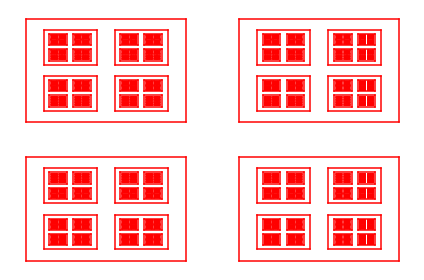

(-0.05500000000000001, 0.05500000000000001, -0.05500000000000001, 0.05500000000000001)

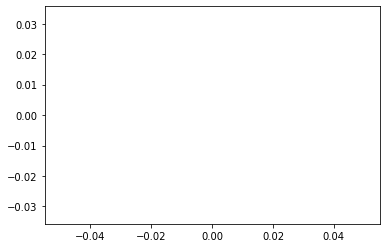

In [ ]:
for each in final_data[64032][5]:
    plt.plot(each[0],each[1], 'r')
            
plt.axis('off')
plt.tight_layout()
plt.show()
plt.axis('equal')           